# Lorenz 96 - 2 Level - ODE


In [1]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import xarray as xr
import numpy as np
import functools as ft

from jaxsw._src.models.lorenz96t import L96TParams, L96TState, rhs_lorenz_96t, Lorenz96t

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 96


* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= (x_{i+1} - x_{i-2})x_{i-1}-x_i + F - \frac{h c}{b} \sum_{j}y_j \\
\frac{dy}{dt} &= -b c (y_{j+2} - y_{j-1})y_{j+1}- c y_j  - \frac{h c}{b} x_i 
\end{aligned}
$$

where $F$ is normally 8 to cause some chaotic behaviour.

In [4]:
F = 18.0  # forcing term
b = 10.0  # coupling coefficient
h = 1.0  # ratio of amplitudes
c = 10.0  # time-scale ratio

In [19]:
# initialize state
ndims = 36, 10
noise = (0.01, 0.0)
key = jrandom.PRNGKey(42)
state = L96TState.init_state(ndims=ndims, noise=noise, key=key)

# rhs
x = state.x
y = state.y
assert x.shape == (ndims[0],)
assert y.shape == (ndims[1] * ndims[0],)
x_dot, y_dot, coupling_term = rhs_lorenz_96t(x=x, y=y, F=F, h=h, c=c, b=b)

assert x_dot.shape == x.shape
assert y_dot.shape == y.shape
assert coupling_term.shape == x.shape

### Model

In [26]:
K = ndims[0]
J = ndims[1]


def s(k, K):
    """A non-dimension coordinate from -1..+1 corresponding to k=0..K"""
    return 2 * (0.5 + k) / K - 1


k = np.arange(K)  # For coordinate in plots
j = np.arange(J * K)  # For coordinate in plots

# Initial conditions
X_init = s(k, K) * (s(k, K) - 1) * (s(k, K) + 1)
Y_init = 0 * s(j, J * K) * (s(j, J * K) - 1) * (s(j, J * K) + 1)

In [27]:
state_init = L96TState(x=jnp.asarray(X_init), y=jnp.asarray(Y_init))
params = L96TParams(F=F, h=h, b=b, c=c)

In [10]:
# # t0 = 0.0
# # t1 = 30.0

# # initialize state
# F = 18.0  # forcing term
# b = 10.0  # coupling coefficient
# h = 1.0   # ratio of amplitudes
# c = 10.0  # time-scale ratio
# ndims = 36, 10
# noise = (0.05, 0.0)
# batchsize = 1
# state_init, params = L96TState.init_state_and_params(
#     ndims=ndims, noise=noise, batchsize=batchsize,
#     F=F, h=h, b=b, c=c
# )

In [28]:
# initialize model
advection = True
l96t_model = Lorenz96t(advection=advection)

# step through
state_dot = l96t_model.equation_of_motion(t=0, state=state_init, args=params)

# state_dot.x.shape
assert state_dot.x.shape == state_init.x.shape
assert state_dot.y.shape == state_init.y.shape

## Time Stepping

In [29]:
dt = 0.005
t0 = 0.0
t1 = 2_000

ts = jnp.arange(t0, t1, 1) * dt

saveat = dfx.SaveAt(ts=ts)
saveat

SaveAt(
  subs=SubSaveAt(
    t0=False,
    t1=False,
    ts=f32[2000],
    steps=False,
    fn=<function save_y>
  ),
  dense=False,
  solver_state=False,
  controller_state=False,
  made_jump=False
)

In [30]:
# Euler, Constant StepSize
solver = dfx.Tsit5()
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)

# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(l96t_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)

## Analysis

In [31]:
ds_sol = xr.Dataset(
    {
        "x": (("time", "Dx"), sol.ys.x.squeeze()),
        "y": (("time", "Dy"), sol.ys.y.squeeze()),
    },
    coords={
        "time": (["time"], sol.ts.squeeze()),
        "Dx": (["Dx"], np.arange(0, ndims[0])),
        "Dy": (["Dy"], np.arange(np.prod(ndims)) / ndims[1]),
    },
    attrs={
        "ode": "lorenz_96_2layer",
        # "sigma": params.sigma,
        # "beta": params.beta,
        # "rho": params.rho,
    },
)
ds_sol

<xarray.Dataset>
Dimensions:  (time: 2000, Dx: 36, Dy: 360)
Coordinates:
  * time     (time) float32 0.0 0.005 0.01 0.015 0.02 ... 9.98 9.985 9.99 9.995
  * Dx       (Dx) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * Dy       (Dy) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 35.5 35.6 35.7 35.8 35.9
Data variables:
    x        (time, Dx) float32 0.05326 0.1464 0.2226 ... 0.2791 3.367 0.4227
    y        (time, Dy) float32 0.0 0.0 0.0 0.0 ... -0.04767 0.01207 -0.04793
Attributes:
    ode:      lorenz_96_2layer

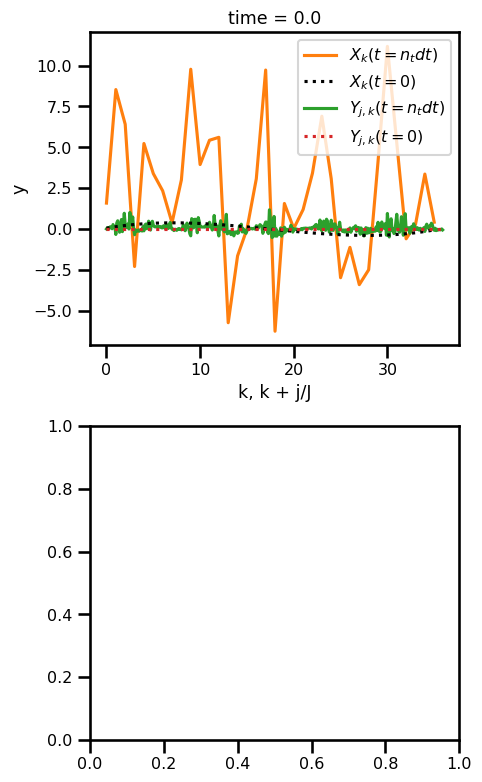

In [32]:
fig, ax = plt.subplots(nrows=2, figsize=(5, 8))

time_step = -1
ds_sol.x.isel(time=time_step).plot(
    ax=ax[0], label="$X_k(t=n_t dt)$", color="tab:orange"
)
ds_sol.x.isel(time=0).plot(
    ax=ax[0], label="$X_k(t=0)$", color="black", linestyle=":", zorder=3
)
ds_sol.y.isel(time=time_step).plot(
    ax=ax[0], label="$Y_{j,k}(t=n_t dt)$", color="tab:green"
)
ds_sol.y.isel(time=0).plot(
    ax=ax[0], label="$Y_{j,k}(t=0)$", color="tab:red", linestyle=":", zorder=3
)
ax[0].legend()
# ax[0].set_ylabel("Time")
ax[0].set_xlabel("k, k + j/J")


# ds_sol.y.plot.contourf(ax=ax[1], cmap="viridis")
# ax[1].set_ylabel("Time")
# ax[1].set_xlabel("Dimension")

plt.tight_layout()
plt.show()

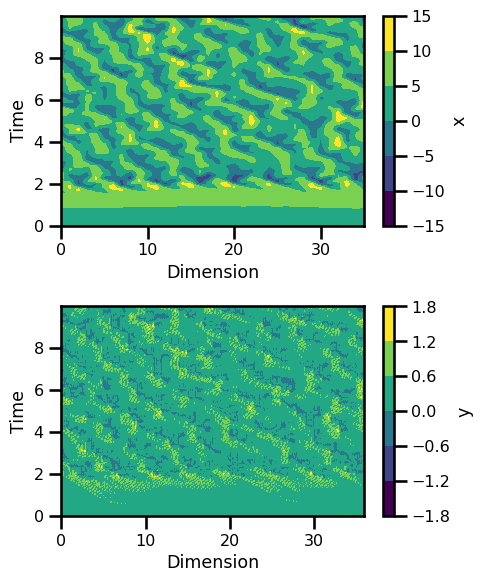

In [33]:
fig, ax = plt.subplots(nrows=2, figsize=(5, 6))

ds_sol.x.plot.contourf(ax=ax[0], cmap="viridis")
ax[0].set_ylabel("Time")
ax[0].set_xlabel("Dimension")


ds_sol.y.plot.contourf(ax=ax[1], cmap="viridis")
ax[1].set_ylabel("Time")
ax[1].set_xlabel("Dimension")

plt.tight_layout()
plt.show()

## Batch of Trajectories

In [34]:
F = 18.0  # forcing term
b = 10.0  # coupling coefficient
h = 1.0  # ratio of amplitudes
c = 10.0  # time-scale ratio

params = L96TParams(F=F, h=h, b=b, c=c)

In [35]:
# initialize state
ndims = 36, 10
noise = 0.001
batchsize = 50
state = L96TState.init_state(ndims=ndims, noise=noise, batchsize=batchsize)

# rhs
x = state.x
y = state.y

rhs_fn = ft.partial(rhs_lorenz_96t, F=F, h=h, c=c, b=b)
fn_batched = jax.vmap(rhs_fn, in_axes=(0, 0))

x_dot, y_dot, _ = fn_batched(state.x, state.y)

assert x_dot.shape == state.x.shape
assert y_dot.shape == state.y.shape

In [36]:
key = jrandom.PRNGKey(123)
keyx, keyy = jrandom.split(key=key, num=2)

X_init_batch = X_init + noise * jrandom.normal(key=keyx, shape=(batchsize, 1))
Y_init_batch = Y_init + noise * jrandom.normal(key=keyy, shape=(batchsize, 1))
state_init = L96TState(x=jnp.asarray(X_init_batch), y=jnp.asarray(Y_init_batch))
params = L96TParams(F=F, h=h, b=b, c=c)
X_init_batch.shape, X_init.shape, Y_init_batch.shape, Y_init.shape

((50, 36), (36,), (50, 360), (360,))

In [37]:
# Euler, Constant StepSize
solver = dfx.Tsit5()
stepsize_controller = dfx.ConstantStepSize()

# integration
integrate = lambda state: dfx.diffeqsolve(
    terms=dfx.ODETerm(l96t_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)
sol = jax.vmap(integrate)(state)

In [38]:
ds_sol = xr.Dataset(
    {
        "x": (("realization", "time", "Dx"), sol.ys.x.squeeze()),
        "y": (("realization", "time", "Dy"), sol.ys.y.squeeze()),
    },
    coords={
        "realization": (["realization"], np.arange(0, len(sol.ys.x))),
        "time": (["time"], sol.ts[0].squeeze()),
        "Dx": (["Dx"], np.arange(0, ndims[0], 1) / ndims[0]),
        "Dy": (["Dy"], np.arange(0, (ndims[0] * ndims[1]), 1) / (ndims[0] * ndims[1])),
    },
    attrs={
        "ode": "lorenz_96_2layer",
        # "sigma": params.sigma,
        # "beta": params.beta,
        # "rho": params.rho,
    },
)
ds_sol

<xarray.Dataset>
Dimensions:      (realization: 50, time: 2000, Dx: 36, Dy: 360)
Coordinates:
  * realization  (realization) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * time         (time) float32 0.0 0.005 0.01 0.015 ... 9.98 9.985 9.99 9.995
  * Dx           (Dx) float64 0.0 0.02778 0.05556 ... 0.9167 0.9444 0.9722
  * Dy           (Dy) float64 0.0 0.002778 0.005556 ... 0.9917 0.9944 0.9972
Data variables:
    x            (realization, time, Dx) float32 0.007382 0.001135 ... 4.926
    y            (realization, time, Dy) float32 0.0007129 0.0001814 ... 0.1033
Attributes:
    ode:      lorenz_96_2layer

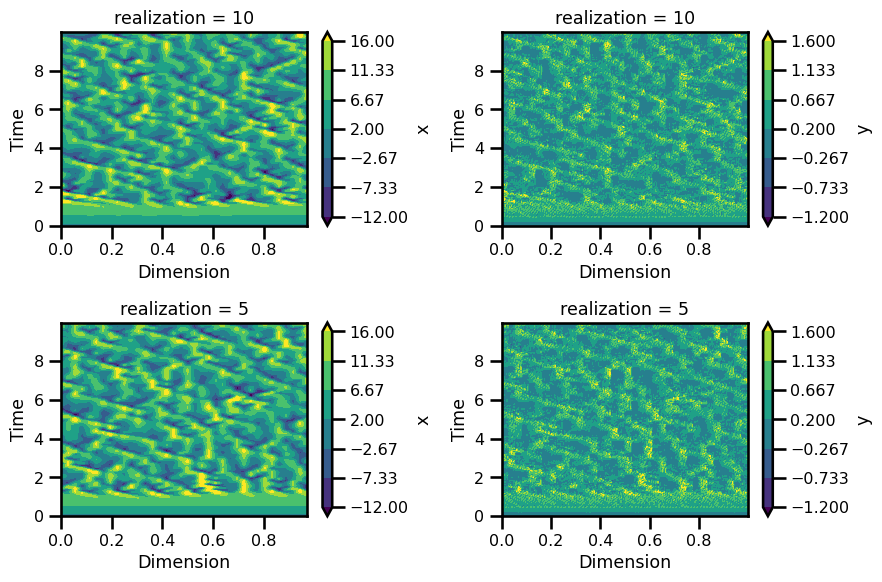

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))

realization = 10
ds_sol.x.isel(realization=realization).plot.contourf(
    ax=ax[0, 0], cmap="viridis", vmax=16, vmin=-12
)
ax[0, 0].set_ylabel("Time")
ax[0, 0].set_xlabel("Dimension")


ds_sol.y.isel(realization=realization).plot.contourf(
    ax=ax[0, 1], cmap="viridis", vmax=1.6, vmin=-1.2
)
ax[0, 1].set_ylabel("Time")
ax[0, 1].set_xlabel("Dimension")

realization = 5
ds_sol.x.isel(realization=realization).plot.contourf(
    ax=ax[1, 0], cmap="viridis", vmax=16, vmin=-12
)
ax[1, 0].set_ylabel("Time")
ax[1, 0].set_xlabel("Dimension")


ds_sol.y.isel(realization=realization).plot.contourf(
    ax=ax[1, 1], cmap="viridis", vmax=1.6, vmin=-1.2
)
ax[1, 1].set_ylabel("Time")
ax[1, 1].set_xlabel("Dimension")

plt.tight_layout()
plt.show()